In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Warnings configuration
# ==============================================================================
import warnings

In [90]:
#pip install skforecast

In [2]:
train = pd.read_csv('2009_tweets.csv')

C:\Users\quain\AppData\Local\Temp\ipykernel_4136\4016266646.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('2009_tweets.csv')


In [92]:
#eda
train.head(5)
#train.shape
print(f'Number of rows with missing values: {train.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.975463843787998


In [3]:
#cleaning up date column
train['weekday'],train['month'],train['day'],train['time'],train['timezone'],train['year'] = train['date'].str.split(' ', 6).str
print(train.head(5))

C:\Users\quain\AppData\Local\Temp\ipykernel_4136\2115707496.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  train['weekday'],train['month'],train['day'],train['time'],train['timezone'],train['year'] = train['date'].str.split(' ', 6).str
C:\Users\quain\AppData\Local\Temp\ipykernel_4136\2115707496.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  train['weekday'],train['month'],train['day'],train['time'],train['timezone'],train['year'] = train['date'].str.split(' ', 6).str


           id                          date  week_number      flag  \
0  1467810672  Mon Apr 06 22:19:49 PDT 2009         15.0  NO_QUERY   
1  1467810917  Mon Apr 06 22:19:53 PDT 2009         15.0  NO_QUERY   
2  1467811184  Mon Apr 06 22:19:57 PDT 2009         15.0  NO_QUERY   
3  1467811193  Mon Apr 06 22:19:57 PDT 2009         15.0  NO_QUERY   
4  1467811372  Mon Apr 06 22:20:00 PDT 2009         15.0  NO_QUERY   

            user                                               Text weekday  \
0  scotthamilton  is upset that he can't update his Facebook by ...     Mon   
1       mattycus  @Kenichan I dived many times for the ball. Man...     Mon   
2        ElleCTF    my whole body feels itchy and like its on fire      Mon   
3         Karoli  @nationwideclass no, it's not behaving at all....     Mon   
4       joy_wolf                      @Kwesidei not the whole crew      Mon   

  month day      time timezone  year  
0   Apr  06  22:19:49      PDT  2009  
1   Apr  06  22:19:53     

In [4]:
train['month'].replace({"Apr": '04', 'May': '05','June':'06'}, inplace=True)

In [5]:
#reordering columns
train= train[['year', 'month', 'day', 'time', 'weekday','timezone', 'date','id','Text','user']]

In [96]:
print(train.head(5))

   year month day      time weekday timezone                          date  \
0  2009    04  06  22:19:49     Mon      PDT  Mon Apr 06 22:19:49 PDT 2009   
1  2009    04  06  22:19:53     Mon      PDT  Mon Apr 06 22:19:53 PDT 2009   
2  2009    04  06  22:19:57     Mon      PDT  Mon Apr 06 22:19:57 PDT 2009   
3  2009    04  06  22:19:57     Mon      PDT  Mon Apr 06 22:19:57 PDT 2009   
4  2009    04  06  22:20:00     Mon      PDT  Mon Apr 06 22:20:00 PDT 2009   

           id                                               Text  \
0  1467810672  is upset that he can't update his Facebook by ...   
1  1467810917  @Kenichan I dived many times for the ball. Man...   
2  1467811184    my whole body feels itchy and like its on fire    
3  1467811193  @nationwideclass no, it's not behaving at all....   
4  1467811372                      @Kwesidei not the whole crew    

            user  
0  scotthamilton  
1       mattycus  
2        ElleCTF  
3         Karoli  
4       joy_wolf  


In [6]:
train['datetime'] = train[train.columns[0:4]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)#creating column datetime, joining columns

train['datetime']

0          2009,04,06,22:19:49
1          2009,04,06,22:19:53
2          2009,04,06,22:19:57
3          2009,04,06,22:19:57
4          2009,04,06,22:20:00
                  ...         
1048570    2009,05,29,07:33:44
1048571    2009,05,29,07:33:43
1048572    2009,05,29,07:33:44
1048573    2009,05,29,07:33:44
1048574    2009,05,29,07:33:45
Name: datetime, Length: 1048575, dtype: object

In [7]:
train['datetime']=train['datetime'].str.replace(',','-')


In [99]:
print(train['datetime'].unique())

['2009-04-06-22:19:49' '2009-04-06-22:19:53' '2009-04-06-22:19:57' ...
 '2009-05-29-07:33:44' '2009-05-29-07:33:43' '2009-05-29-07:33:45']


In [8]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['week_of_year'] = train.datetime.apply(lambda x: x.weekofyear)
#converting to datetime format and adding week of year

In [101]:
print(train['week_of_year'].unique())

[15. 16. 17. 18. 19. 20. 21. 22. 23. nan 24. 25. 26.]


In [102]:
#train.to_csv('check1.csv')

In [9]:
#cleaning text column
punctuation_signs = list("™?:()!.€"",;/'@")
for punct_sign in punctuation_signs:
        train['Text'] = train['Text'].str.replace(punct_sign, '')

C:\Users\quain\AppData\Local\Temp\ipykernel_4136\983603698.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train['Text'] = train['Text'].str.replace(punct_sign, '')


In [ ]:
#EDA
train["user"].value_counts().plot(kind="bar")

In [ ]:
train["month"].value_counts().plot(kind="bar")

In [13]:
train['word_count'] = train['Text'].apply(lambda x: len(str(x).split(" ")))
train[['Text','word_count']].head()#adding wordcount column

,Text,word_count
0,is upset that he cant update his Facebook by t...,22
1,Kenichan I dived many times for the ball Manag...,19
2,my whole body feels itchy and like its on fire,11
3,nationwideclass no its not behaving at all im ...,22
4,Kwesidei not the whole crew,6


In [ ]:
train.head()

In [10]:
train['char_count'] = train['Text'].str.len() 
train[['Text','char_count']].head()#adding character count column

,Text,char_count
0,is upset that he cant update his Facebook by t...,105
1,Kenichan I dived many times for the ball Manag...,87
2,my whole body feels itchy and like its on fire,47
3,nationwideclass no its not behaving at all im ...,102
4,Kwesidei not the whole crew,28


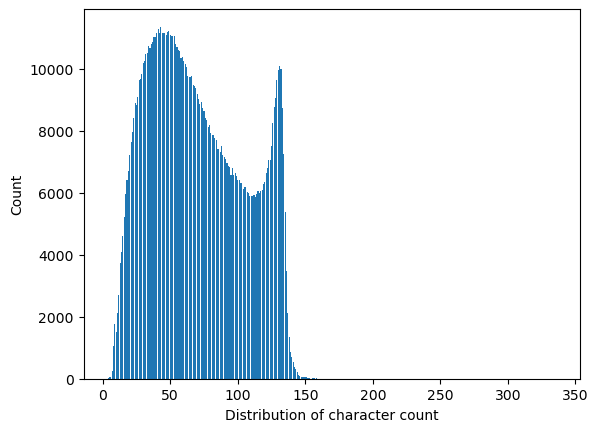

In [11]:
x = train["char_count"].value_counts()
plt.bar(x.index, x.values)
plt.xlabel("Distribution of character count")
plt.ylabel("Count")
plt.show()

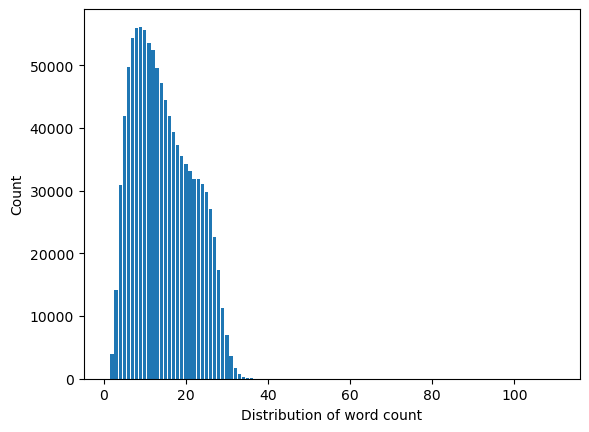

In [14]:
x = train["word_count"].value_counts()
plt.bar(x.index, x.values)
plt.xlabel("Distribution of word count")
plt.ylabel("Count")
plt.show()

In [15]:
def avg_word(sentence):#average word count
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

In [16]:
train['avg_word'] = train['Text'].apply(lambda x: avg_word(x))
train[['Text','avg_word']].head()#adding avg. word count column

,Text,avg_word
0,is upset that he cant update his Facebook by t...,4.000000
1,Kenichan I dived many times for the ball Manag...,3.833333
2,my whole body feels itchy and like its on fire,3.700000
3,nationwideclass no its not behaving at all im ...,3.857143
4,Kwesidei not the whole crew,4.600000


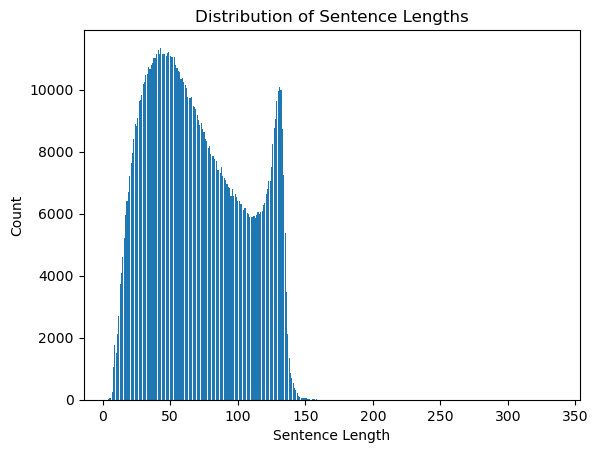

In [17]:
x = train["Text"].str.len().value_counts()
plt.bar(x.index, x.values)
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.show()

In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [20]:
train['stopwords'] = train['Text'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['Text','stopwords']].head()#removing stpp words

,Text,stopwords
0,is upset that he cant update his Facebook by t...,9
1,Kenichan I dived many times for the ball Manag...,5
2,my whole body feels itchy and like its on fire,4
3,nationwideclass no its not behaving at all im ...,14
4,Kwesidei not the whole crew,2


In [21]:
train['hastags'] = train['Text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
train[['Text','hastags']].head()#removing hastags

,Text,hastags
0,is upset that he cant update his Facebook by t...,0
1,Kenichan I dived many times for the ball Manag...,0
2,my whole body feels itchy and like its on fire,0
3,nationwideclass no its not behaving at all im ...,0
4,Kwesidei not the whole crew,0


In [22]:
train['numerics'] = train['Text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train[['Text','numerics']].head()#removing numeric characters

,Text,numerics
0,is upset that he cant update his Facebook by t...,0
1,Kenichan I dived many times for the ball Manag...,0
2,my whole body feels itchy and like its on fire,0
3,nationwideclass no its not behaving at all im ...,0
4,Kwesidei not the whole crew,0


In [23]:
train['upper'] = train['Text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
train[['Text','upper']].head()#changing to lowercase

,Text,upper
0,is upset that he cant update his Facebook by t...,0
1,Kenichan I dived many times for the ball Manag...,1
2,my whole body feels itchy and like its on fire,0
3,nationwideclass no its not behaving at all im ...,1
4,Kwesidei not the whole crew,0


In [24]:
train['Text'] = train['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train['Text'] = train['Text'].str.replace('[^\w\s]','')
train['Text'].head()

C:\Users\quain\AppData\Local\Temp\ipykernel_4136\4144297705.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['Text'] = train['Text'].str.replace('[^\w\s]','')


0    is upset that he cant update his facebook by t...
1    kenichan i dived many times for the ball manag...
2       my whole body feels itchy and like its on fire
3    nationwideclass no its not behaving at all im ...
4                          kwesidei not the whole crew
Name: Text, dtype: object

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
train['Text'] = train['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train['Text'].head()#using nltk to remove stopwords

In [ ]:
freq = pd.Series(' '.join(train['Text']).split()).value_counts()[:10]
freq#frequency of words occuring

In [ ]:
#freq = list(freq.index)
#train['Text'] = train['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
#train['Text'].head()

In [ ]:
freq = pd.Series(' '.join(train['Text']).split()).value_counts()[-10:]
freq

In [ ]:
freq = list(freq.index)
train['Text'] = train['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train['Text'].head()

In [ ]:
#pip install textblob

In [25]:
from textblob import TextBlob
train['Text'][:5].apply(lambda x: str(TextBlob(x).correct()))
#processing textual data

0    is upset that he can update his facebook by te...
1    kenichan i dived many times for the ball manag...
2       my whole body feels itchy and like its on fire
3    nationwideclass no its not behaving at all in ...
4                          kwesidei not the whole crew
Name: Text, dtype: object

In [26]:
nltk.download('punkt')
TextBlob(train['Text'][1]).words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\quain\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


WordList(['kenichan', 'i', 'dived', 'many', 'times', 'for', 'the', 'ball', 'managed', 'to', 'save', '50', 'the', 'rest', 'go', 'out', 'of', 'bounds'])

In [27]:
from nltk.stem import PorterStemmer
st = PorterStemmer()
train['Text'][:10].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0    is upset that he cant updat hi facebook by tex...
1    kenichan i dive mani time for the ball manag t...
2         my whole bodi feel itchi and like it on fire
3    nationwideclass no it not behav at all im mad ...
4                          kwesidei not the whole crew
5                                           need a hug
6    loltrish hey long time no see ye rain a bit on...
7                    tatiana_k nope they didnt have it
8                                twittera que me muera
9                   spring break in plain citi it snow
Name: Text, dtype: object

In [28]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\quain\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [29]:
nltk.download('wordnet')
from textblob import Word
train['Text'] = train['Text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
train['Text'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\quain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    is upset that he cant update his facebook by t...
1    kenichan i dived many time for the ball manage...
2         my whole body feel itchy and like it on fire
3    nationwideclass no it not behaving at all im m...
4                          kwesidei not the whole crew
Name: Text, dtype: object

In [30]:
TextBlob(train['Text'][0]).ngrams(2)#processing contineous sequence

[WordList(['is', 'upset']),
 WordList(['upset', 'that']),
 WordList(['that', 'he']),
 WordList(['he', 'cant']),
 WordList(['cant', 'update']),
 WordList(['update', 'his']),
 WordList(['his', 'facebook']),
 WordList(['facebook', 'by']),
 WordList(['by', 'texting']),
 WordList(['texting', 'it']),
 WordList(['it', 'and']),
 WordList(['and', 'might']),
 WordList(['might', 'cry']),
 WordList(['cry', 'a']),
 WordList(['a', 'a']),
 WordList(['a', 'result']),
 WordList(['result', 'school']),
 WordList(['school', 'today']),
 WordList(['today', 'also']),
 WordList(['also', 'blah'])]

In [31]:
tf1 = (train['Text'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,the,2
1,kenichan,1
2,to,1
3,of,1
4,out,1
5,go,1
6,rest,1
7,50,1
8,save,1
9,managed,1


In [32]:
import numpy as np

for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(train.shape[0]/(len(train[train['Text'].str.contains(word)])))

tf1

,words,tf,idf
0,the,2,1.002804
1,kenichan,1,11.297993
2,to,1,0.813045
3,of,1,1.901793
4,out,1,2.255626
5,go,1,1.486916
6,rest,1,4.712883
7,50,1,5.602967
8,save,1,6.057061
9,managed,1,7.346750


In [33]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,the,2,1.002804,2.005608
1,kenichan,1,11.297993,11.297993
2,to,1,0.813045,0.813045
3,of,1,1.901793,1.901793
4,out,1,2.255626,2.255626
5,go,1,1.486916,1.486916
6,rest,1,4.712883,4.712883
7,50,1,5.602967,5.602967
8,save,1,6.057061,6.057061
9,managed,1,7.346750,7.346750


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(train['Text'])

train_vect
print(train_vect)

  (0, 92)	0.4508376110305616
  (0, 862)	0.23552286605746148
  (0, 726)	0.299671558698507
  (0, 702)	0.44839301800386444
  (0, 282)	0.39691900343144804
  (0, 898)	0.3658763466231582
  (0, 900)	0.3987541724591794
  (1, 701)	0.5037819972611508
  (1, 720)	0.5580465988965944
  (1, 66)	0.5766611317208297
  (1, 860)	0.3197649634621674
  (2, 505)	0.4234241073973746
  (2, 297)	0.48769734046074364
  (2, 97)	0.7634548640111307
  (3, 542)	0.9056733182703999
  (3, 445)	0.42397622642441046
  (5, 432)	0.828233760976871
  (5, 597)	0.5603827595296873
  (6, 429)	0.35835417399123237
  (6, 846)	0.24064336926760016
  (6, 308)	0.3304918268713932
  (6, 518)	0.21290447143022515
  (6, 88)	0.5587813210009408
  (6, 684)	0.2727879327784512
  (6, 990)	0.26604338860861587
  :	:
  (1048568, 914)	0.17517516650646606
  (1048568, 862)	0.19373262221257587
  (1048569, 574)	0.4303877521449729
  (1048569, 418)	0.32408298297999755
  (1048569, 441)	0.4349779185882359
  (1048569, 799)	0.41014304338393825
  (1048569, 940)	0.35

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(train['Text'])
train_bow
print(train_bow)

  (0, 456)	1
  (0, 893)	1
  (0, 824)	1
  (0, 399)	1
  (0, 148)	1
  (0, 891)	1
  (0, 417)	1
  (0, 288)	1
  (0, 138)	1
  (0, 459)	1
  (0, 42)	1
  (0, 546)	1
  (0, 198)	1
  (0, 710)	1
  (0, 852)	1
  (0, 35)	1
  (0, 107)	1
  (1, 535)	1
  (1, 849)	1
  (1, 330)	1
  (1, 826)	2
  (1, 78)	1
  (1, 851)	1
  (1, 704)	1
  (1, 686)	1
  :	:
  (1048570, 533)	1
  (1048570, 573)	1
  (1048571, 849)	1
  (1048571, 601)	1
  (1048572, 459)	1
  (1048572, 826)	1
  (1048572, 497)	2
  (1048572, 411)	1
  (1048572, 469)	1
  (1048572, 341)	1
  (1048572, 706)	1
  (1048572, 179)	1
  (1048572, 701)	1
  (1048572, 602)	1
  (1048572, 569)	1
  (1048572, 963)	1
  (1048573, 447)	1
  (1048573, 373)	1
  (1048574, 148)	1
  (1048574, 410)	1
  (1048574, 837)	1
  (1048574, 908)	1
  (1048574, 931)	1
  (1048574, 209)	1
  (1048574, 847)	1


In [37]:
train['Text'][:10].apply(lambda x: TextBlob(x).sentiment)

0                                     (0.0, 0.0)
1                                     (0.5, 0.5)
2                                     (0.2, 0.4)
3                                  (-0.625, 1.0)
4                                     (0.2, 0.4)
5                                     (0.0, 0.0)
6       (0.2733333333333333, 0.5599999999999999)
7                                     (0.0, 0.0)
8                                     (0.0, 0.0)
9    (-0.21428571428571427, 0.35714285714285715)
Name: Text, dtype: object

In [38]:
train['sentiment'] = train['Text'].apply(lambda x: TextBlob(x).sentiment[0] )
train[['Text','sentiment']].head()
train.head(10)

,year,month,day,time,weekday,timezone,date,id,Text,user,datetime,week_of_year,char_count,word_count,avg_word,stopwords,hastags,numerics,upper,sentiment
0,2009,04,06,22:19:49,Mon,PDT,Mon Apr 06 22:19:49 PDT 2009,1467810672,is upset that he cant update his facebook by t...,scotthamilton,2009-04-06 22:19:49,15.0,105,22,4.000000,9,0,0,0,0.000000
1,2009,04,06,22:19:53,Mon,PDT,Mon Apr 06 22:19:53 PDT 2009,1467810917,kenichan i dived many time for the ball manage...,mattycus,2009-04-06 22:19:53,15.0,87,19,3.833333,5,0,0,1,0.500000
2,2009,04,06,22:19:57,Mon,PDT,Mon Apr 06 22:19:57 PDT 2009,1467811184,my whole body feel itchy and like it on fire,ElleCTF,2009-04-06 22:19:57,15.0,47,11,3.700000,4,0,0,0,0.200000
3,2009,04,06,22:19:57,Mon,PDT,Mon Apr 06 22:19:57 PDT 2009,1467811193,nationwideclass no it not behaving at all im m...,Karoli,2009-04-06 22:19:57,15.0,102,22,3.857143,14,0,0,1,-0.625000
4,2009,04,06,22:20:00,Mon,PDT,Mon Apr 06 22:20:00 PDT 2009,1467811372,kwesidei not the whole crew,joy_wolf,2009-04-06 22:20:00,15.0,28,6,4.600000,2,0,0,0,0.200000
5,2009,04,06,22:20:03,Mon,PDT,Mon Apr 06 22:20:03 PDT 2009,1467811592,need a hug,mybirch,2009-04-06 22:20:03,15.0,11,4,2.666667,1,0,0,0,0.000000
6,2009,04,06,22:20:03,Mon,PDT,Mon Apr 06 22:20:03 PDT 2009,1467811594,loltrish hey long time no see yes rain a bit o...,coZZ,2009-04-06 22:20:03,15.0,89,24,3.473684,5,0,0,1,0.273333
7,2009,04,06,22:20:05,Mon,PDT,Mon Apr 06 22:20:05 PDT 2009,1467811795,tatiana_k nope they didnt have it,2Hood4Hollywood,2009-04-06 22:20:05,15.0,34,7,4.666667,3,0,0,0,0.000000
8,2009,04,06,22:20:09,Mon,PDT,Mon Apr 06 22:20:09 PDT 2009,1467812025,twittera que me muera,mimismo,2009-04-06 22:20:09,15.0,23,6,4.500000,1,0,0,0,0.000000
9,2009,04,06,22:20:16,Mon,PDT,Mon Apr 06 22:20:16 PDT 2009,1467812416,spring break in plain city it snowing,erinx3leannexo,2009-04-06 22:20:16,15.0,39,8,4.571429,2,0,0,0,-0.214286


In [39]:
sns.boxplot(data=train, x='month', y='sentiment', width=.5,ax.grid(True))

SyntaxError: positional argument follows keyword argument (604478291.py, line 1)

In [ ]:
sns.boxplot(data=train, x='weekday', y='sentiment', width=.5,ax.grid(True))

In [ ]:
pip install pmdarima

In [ ]:
train.head(5)

In [40]:
#taking subset of dataset for model purposes
model= train[['id','Text','user','sentiment','datetime','week_of_year']]
#rename column
model.head()

,id,Text,user,sentiment,datetime,week_of_year
0,1467810672,is upset that he cant update his facebook by t...,scotthamilton,0.000,2009-04-06 22:19:49,15.0
1,1467810917,kenichan i dived many time for the ball manage...,mattycus,0.500,2009-04-06 22:19:53,15.0
2,1467811184,my whole body feel itchy and like it on fire,ElleCTF,0.200,2009-04-06 22:19:57,15.0
3,1467811193,nationwideclass no it not behaving at all im m...,Karoli,-0.625,2009-04-06 22:19:57,15.0
4,1467811372,kwesidei not the whole crew,joy_wolf,0.200,2009-04-06 22:20:00,15.0


In [41]:
model['date'] = pd.to_datetime(model['datetime']).dt.date
model['time'] = pd.to_datetime(model['datetime']).dt.time
print(model.head(5))


C:\Users\quain\AppData\Local\Temp\ipykernel_4136\1745950110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model['date'] = pd.to_datetime(model['datetime']).dt.date


           id                                               Text  \
0  1467810672  is upset that he cant update his facebook by t...   
1  1467810917  kenichan i dived many time for the ball manage...   
2  1467811184       my whole body feel itchy and like it on fire   
3  1467811193  nationwideclass no it not behaving at all im m...   
4  1467811372                        kwesidei not the whole crew   

            user  sentiment            datetime  week_of_year        date  \
0  scotthamilton      0.000 2009-04-06 22:19:49          15.0  2009-04-06   
1       mattycus      0.500 2009-04-06 22:19:53          15.0  2009-04-06   
2        ElleCTF      0.200 2009-04-06 22:19:57          15.0  2009-04-06   
3         Karoli     -0.625 2009-04-06 22:19:57          15.0  2009-04-06   
4       joy_wolf      0.200 2009-04-06 22:20:00          15.0  2009-04-06   

       time  
0  22:19:49  
1  22:19:53  
2  22:19:57  
3  22:19:57  
4  22:20:00  


C:\Users\quain\AppData\Local\Temp\ipykernel_4136\1745950110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model['time'] = pd.to_datetime(model['datetime']).dt.time


In [42]:
#model = model.drop(model.index[0])#causing issues
model= train[['datetime','id','Text','user','sentiment','date','week_of_year','weekday','month']]
#model.to_csv('check4.csv')
model.head()


,datetime,id,Text,user,sentiment,date,week_of_year,weekday,month
0,2009-04-06 22:19:49,1467810672,is upset that he cant update his facebook by t...,scotthamilton,0.000,Mon Apr 06 22:19:49 PDT 2009,15.0,Mon,04
1,2009-04-06 22:19:53,1467810917,kenichan i dived many time for the ball manage...,mattycus,0.500,Mon Apr 06 22:19:53 PDT 2009,15.0,Mon,04
2,2009-04-06 22:19:57,1467811184,my whole body feel itchy and like it on fire,ElleCTF,0.200,Mon Apr 06 22:19:57 PDT 2009,15.0,Mon,04
3,2009-04-06 22:19:57,1467811193,nationwideclass no it not behaving at all im m...,Karoli,-0.625,Mon Apr 06 22:19:57 PDT 2009,15.0,Mon,04
4,2009-04-06 22:20:00,1467811372,kwesidei not the whole crew,joy_wolf,0.200,Mon Apr 06 22:20:00 PDT 2009,15.0,Mon,04


In [ ]:

model.nunique()
#model = pd.date_range("2018-01-01", periods=48, freq="D")
model.head()

In [43]:
model2=model[['datetime','id','Text','sentiment','week_of_year','month','weekday']]
model2.head()

,datetime,id,Text,sentiment,week_of_year,month,weekday
0,2009-04-06 22:19:49,1467810672,is upset that he cant update his facebook by t...,0.000,15.0,04,Mon
1,2009-04-06 22:19:53,1467810917,kenichan i dived many time for the ball manage...,0.500,15.0,04,Mon
2,2009-04-06 22:19:57,1467811184,my whole body feel itchy and like it on fire,0.200,15.0,04,Mon
3,2009-04-06 22:19:57,1467811193,nationwideclass no it not behaving at all im m...,-0.625,15.0,04,Mon
4,2009-04-06 22:20:00,1467811372,kwesidei not the whole crew,0.200,15.0,04,Mon


In [44]:
model2.rename(columns = {'datetime':'date'}, inplace = True)
model2.to_csv('check4.csv')

C:\Users\quain\AppData\Local\Temp\ipykernel_4136\3560204100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model2.rename(columns = {'datetime':'date'}, inplace = True)


C:\Users\quain\AppData\Local\Temp\ipykernel_4136\2215937412.py:1: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  model2= pd.read_csv('check4.csv', parse_dates=['date'], index_col='date')


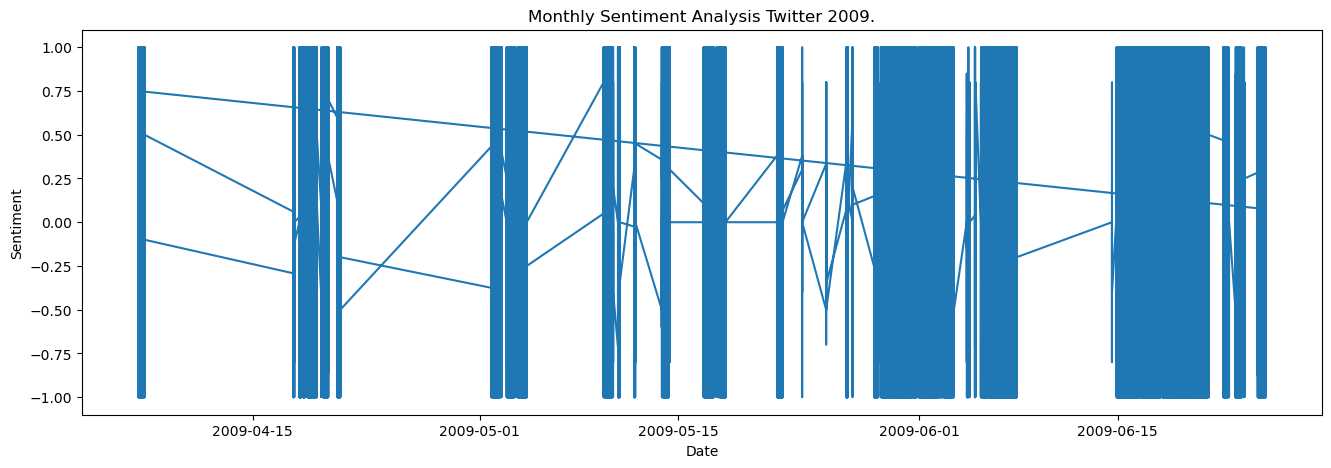

In [45]:
model2= pd.read_csv('check4.csv', parse_dates=['date'], index_col='date')

# Draw Plot
def plot_df(model2, x, y, title="", xlabel='Date', ylabel='Sentiment', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(model2, x=model2.index, y=model2.sentiment, title='Monthly Sentiment Analysis Twitter 2009.')  

In [ ]:
model2.head()

C:\Users\quain\AppData\Local\Temp\ipykernel_4136\1988491170.py:2: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('check4.csv', parse_dates=['weekday'], index_col='weekday').plot(title='Trend Only', legend=False, ax=axes[0])
C:\Users\quain\AppData\Local\Temp\ipykernel_4136\1988491170.py:4: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('check4.csv', parse_dates=['week_of_year'], index_col='week_of_year').plot(title='Seasonality Only', legend=False, ax=axes[1])
C:\Users\quain\AppData\Local\Temp\ipykernel_4136\1988491170.py:6: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('check4.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])


<Axes: title={'center': 'Trend and Seasonality'}, xlabel='date'>

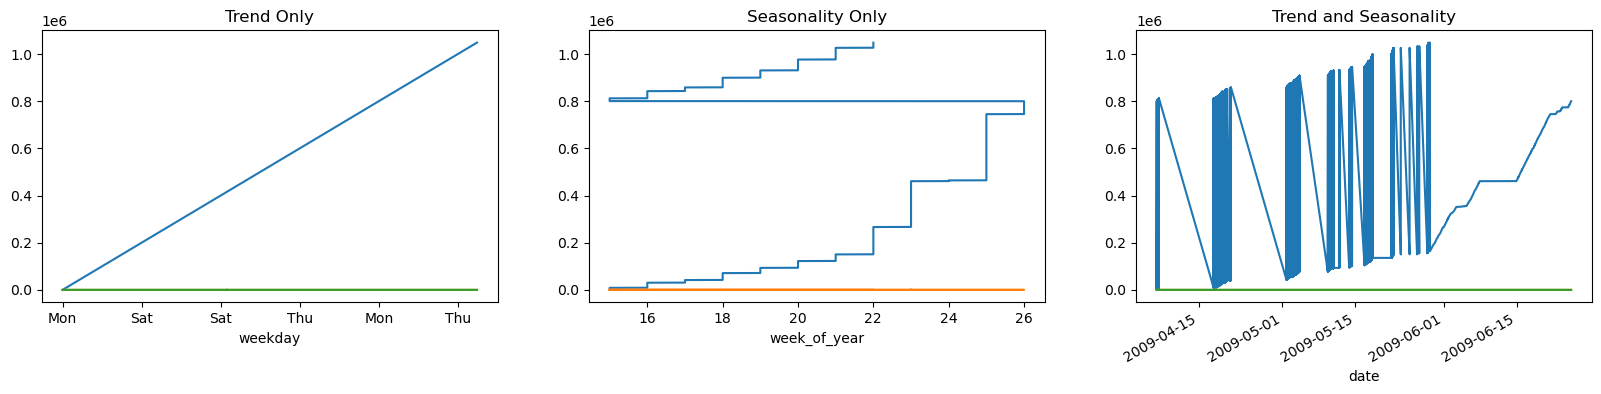

In [46]:
fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)
pd.read_csv('check4.csv', parse_dates=['weekday'], index_col='weekday').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('check4.csv', parse_dates=['week_of_year'], index_col='week_of_year').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('check4.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
%matplotlib inline

# Import Data
model = pd.read_csv('check4.csv', parse_dates=['date'], index_col='date')

# Multiplicative Decomposition 
#result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(model['sentiment'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

C:\Users\quain\AppData\Local\Temp\ipykernel_4136\2835221080.py:6: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  model = pd.read_csv('check4.csv', parse_dates=['date'], index_col='date')


ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

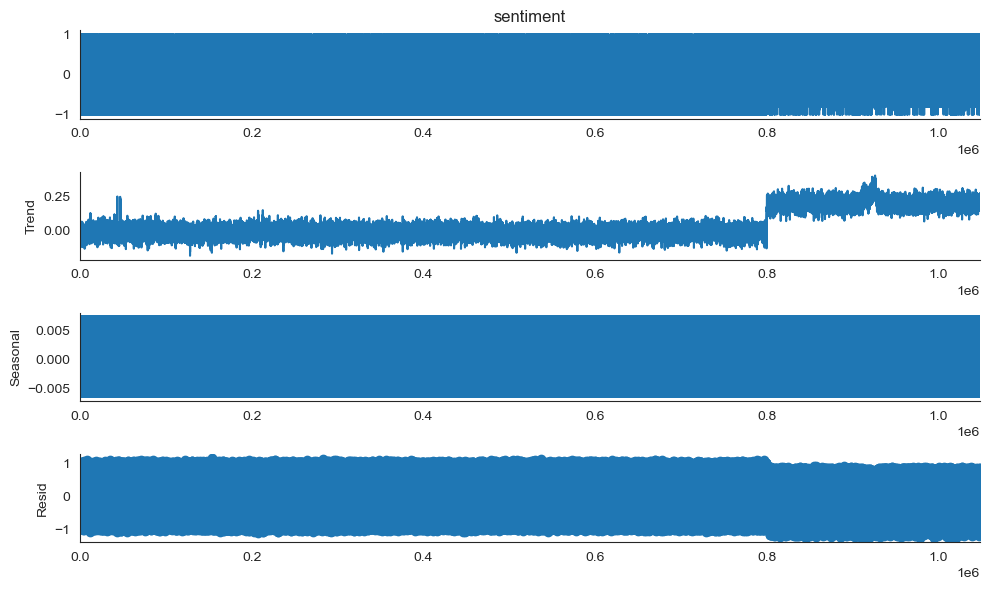

In [48]:
# Decompose the time series,Visualize the Time-Series and Check it for Stationarity
#
# look at the different components of the time series,using the seasonal_decompose function of the statsmodels library
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
plt.rcParams["figure.figsize"] = (10,6)
result = seasonal_decompose(train['sentiment'], model='additive', period = 90)
#multiplicative model since magnitude of the seasonal component not changing with time
result.plot()
plt.show()

C:\Users\quain\AppData\Local\Temp\ipykernel_4136\2792021542.py:8: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(data=train[['sentiment', 'week_of_year', 'month']], palette=sns.color_palette("mako_r", 3))


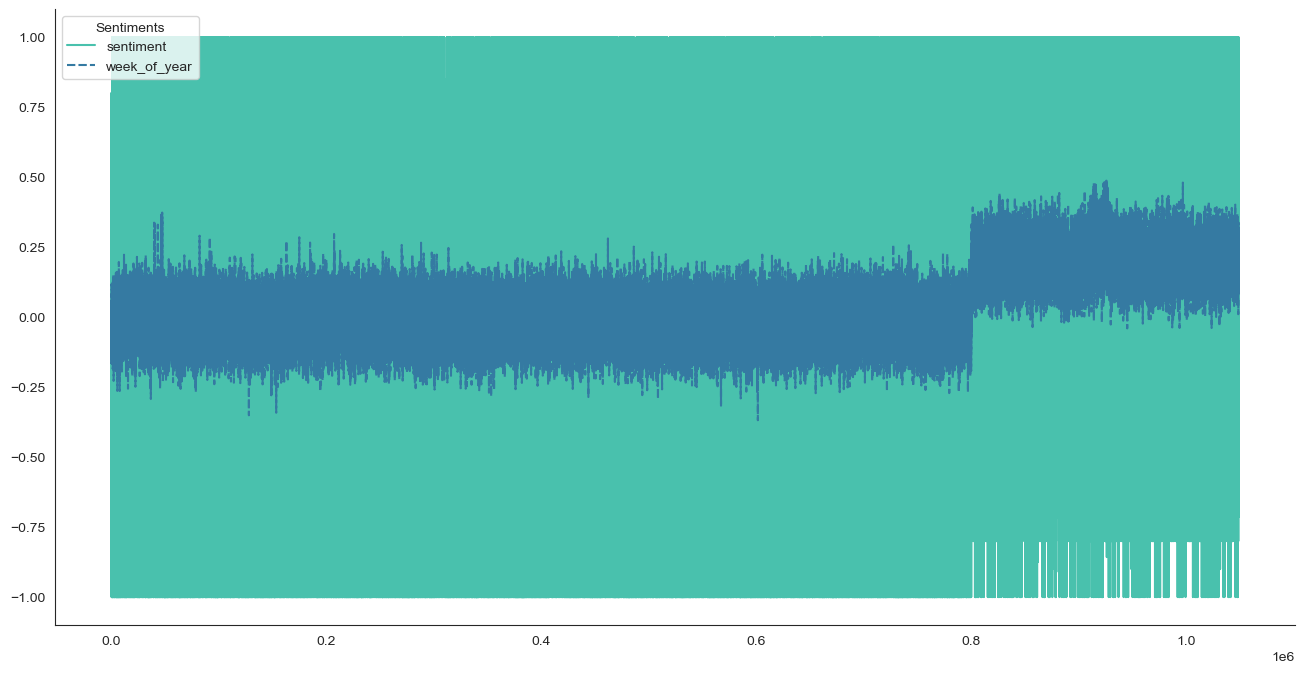

In [49]:
def check_stationarity(train):
    # Visualize the data
    fig, ax = plt.subplots(figsize=(16, 8))
    #plt.title(title_string, fontsize=14)
    if train.index.size > 3:
        train['week_of_year'] = train['sentiment'].rolling(window=12).mean()
        train['week_of_year'] = train['sentiment'].rolling(window=25).mean()
        sns.lineplot(data=train[['sentiment', 'week_of_year', 'month']], palette=sns.color_palette("mako_r", 3))
        #plt.legend(title='Sentiments', loc='upper left', labels=labels)
        plt.legend(title='Sentiments', loc='upper left')
    else:
        sns.lineplot(data=train[['sentiment']])
    
    plt.show()
check_stationarity(train)

In [ ]:
def check_stationarity(model, title_string, labels):
    # Visualize the data
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.title(title_string, fontsize=14)
    if model.index.size > 3:
        model['week_of_year'] = model['sentiment'].rolling(window=12).mean()
        model['week_of_year'] = model['sentiment'].rolling(window=25).mean()
        sns.lineplot(data=model[['sentiment', 'week_of_year', 'date']], palette=sns.color_palette("mako_r", 3))
        plt.legend(title='Sentiments', loc='upper left', labels=labels)
    else:
        sns.lineplot(data=train[['sentiment']])
    
    plt.show()
    
    sentiment =model['sentiment'].dropna()
    # Perform an Ad Fuller Test
    # the default alpha = .05 stands for a 95% confidence interval
    adf_test = pm.arima.ADFTest(alpha = 0.05) 
    print(adf_test.should_diff(sentiment))
    
model['sentiment']= pd.DataFrame(train['sentiment'], columns=['sentiment'])
#train.index = pd.to_datetime(train['month']) 
title = "Sentiment in Twitter 2009 dataset"
labels = ['sentiment', 'ma_12_month', 'ma_25_month']
check_stationarity(train, title, labels)

In [ ]:
model2.head()

Train dates : 2009-04-06 22:19:49 --- 2009-06-22 13:52:10  (n=748575)
Test dates  : 2009-04-06 22:22:45 --- 2009-06-25 10:28:31  (n=300000)


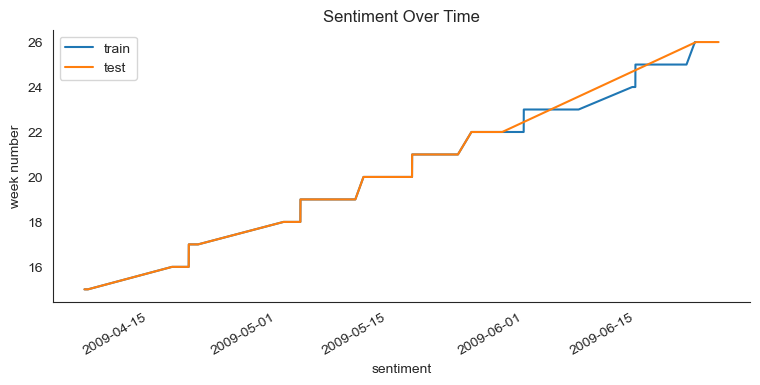

In [50]:
# Split data into train-test
# ==============================================================================
steps = 300000#third of dataset approx being used for test set
model_train = model2[:-steps]
model_test  = model2[-steps:]

print(f"Train dates : {model_train.index.min()} --- {model_train.index.max()}  (n={len(model_train)})")
print(f"Test dates  : {model_test.index.min()} --- {model_test.index.max()}  (n={len(model_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
model_train['week_of_year'].plot(ax=ax, label='train')
model_test['week_of_year'].plot(ax=ax, label='test')

ax.set_xlabel('sentiment')
ax.set_ylabel('week number')
ax.set_title('Sentiment Over Time')

ax.legend();
plt.show()

In [61]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=model_train['sentiment'])
forecaster

C:\Users\quain\anaconda3\lib\site-packages\skforecast\utils\utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\quain\anaconda3\lib\site-packages\skforecast\utils\utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 748574] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-05 14:01:09 
Last fit date: 2023-05-05 14:14:35 
Skforecast version: 0.7.0 
Python version: 3.10.9 
Forecaster id: None 

In [66]:
# Predictions_1 month
# ==============================================================================
steps = 300000
predictions_1month = forecaster.predict(steps=steps)
predictions_1month.head(5)

C:\Users\quain\anaconda3\lib\site-packages\skforecast\utils\utils.py:674: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


KeyboardInterrupt: 

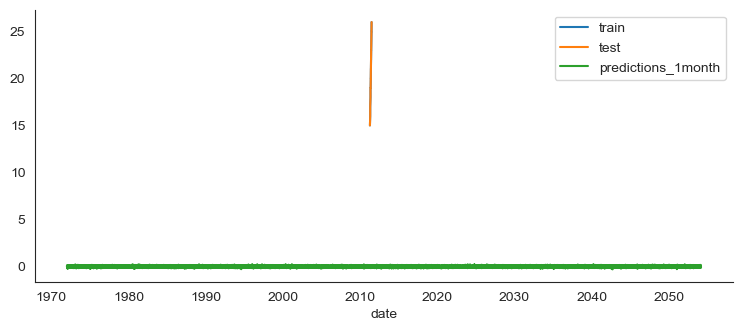

In [65]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
model_train['week_of_year'].plot(ax=ax, label='train')
model_test['week_of_year'].plot(ax=ax, label='test')
predictions_1month.plot(ax=ax, label='predictions_1month')
ax.legend();

In [ ]:
# Predictions_1 month
# ==============================================================================
steps = 900000
predictions_3month = forecaster.predict(steps=steps)
predictions_3month.head(5)

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
model_train['week_of_year'].plot(ax=ax, label='train')
model_test['week_of_year'].plot(ax=ax, label='test')
predictions_3month.plot(ax=ax, label='predictions_3month')
ax.legend();

In [59]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = model_test['week_of_year'],
                y_pred = predictions_3month
            )

print(f"Test error (mse): {error_mse}")

NameError: name 'predictions_3month' is not defined

In [63]:
model2.head()

,Unnamed: 0,id,Text,sentiment,week_of_year,month,weekday
date,,,,,,,
2009-04-06 22:19:49,0,1467810672,is upset that he cant update his facebook by t...,0.000,15.0,4,Mon
2009-04-06 22:19:53,1,1467810917,kenichan i dived many time for the ball manage...,0.500,15.0,4,Mon
2009-04-06 22:19:57,2,1467811184,my whole body feel itchy and like it on fire,0.200,15.0,4,Mon
2009-04-06 22:19:57,3,1467811193,nationwideclass no it not behaving at all im m...,-0.625,15.0,4,Mon
2009-04-06 22:20:00,4,1467811372,kwesidei not the whole crew,0.200,15.0,4,Mon


In [57]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 2# This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = model2['sentiment'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(model2)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop param_grid:   0%|                                              | 0/6 [00:00<?, ?it/s]C:\Users\quain\anaconda3\lib\site-packages\skforecast\model_selection\model_selection.py:370: RuntimeWarning: The forecaster will be fit 14564 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

  warnings.warn(
C:\Users\quain\anaconda3\lib\site-packages\skforecast\utils\utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\quain\anaconda3\lib\site-packages\skforecast\utils\utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\quain\anaconda3\lib\site-packages\skforecast\utils\utils.py:674: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\quain\anaconda3\lib\site-packages\sk

C:\Users\quain\anaconda3\lib\site-packages\skforecast\utils\utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\quain\anaconda3\lib\site-packages\skforecast\utils\utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\quain\anaconda3\lib\site-packages\skforecast\utils\utils.py:674: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\quain\anaconda3\lib\site-packages\skforecast\utils\utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\quain\anaconda3\lib\site-packages\skforecast\utils\utils.py:616: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warni

KeyboardInterrupt: 

In [ ]:
# Grid Search results
# ==============================================================================
results_grid

In [ ]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['y'])

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();